# Samira Chile

Aplicação do modelo Sarima para o número de mortes da Argentina

In [ ]:
# Importando as blibiotecas
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from itertools import product

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [ ]:
url = 'https://raw.githubusercontent.com/aaasatoou/bootcamp_blue_Projeto2/main/datasets/serie%20temporal%20pais/S%C3%A9ries%20Temporais%20Chile.csv'
serie_chi = pd.read_csv(url)
serie_chi.drop('Unnamed: 0',axis=1,inplace=True)
serie_chi['Date'] = pd.to_datetime(serie_chi['Date'],format='%Y-%m-%d')
serie_chi['Mês'] = serie_chi['Date'].dt.month
serie_chi.set_index('Date',inplace=True)
serie_chi.head()

,Confirmed,Recovered,Deaths,Ano,Mês
Date,,,,,
2020-01-22,0,0.0,0,2020,1
2020-01-23,0,0.0,0,2020,1
2020-01-24,0,0.0,0,2020,1
2020-01-25,0,0.0,0,2020,1
2020-01-26,0,0.0,0,2020,1


In [ ]:
# Separação entre treino e teste
treino = serie_chi[(serie_chi['Ano']<=2021)&(serie_chi['Mês']<12)]
teste = serie_chi[(serie_chi['Ano']==2021)&(serie_chi['Mês'] == 12)]

In [ ]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [ ]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 4, treino['Deaths'])
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(1, 3, 2, 3)",7424.929699
1,"(1, 1, 0, 1)",7432.489953
2,"(1, 1, 2, 3)",7432.746595
3,"(1, 1, 0, 2)",7432.776623
4,"(1, 3, 1, 1)",7433.376730
...,...,...
250,"(3, 0, 0, 0)",7845.425849
251,"(0, 0, 0, 0)",7846.604996
252,"(0, 1, 0, 0)",7847.524855
253,"(1, 0, 0, 0)",7847.605898


In [ ]:
best_model = SARIMAX(treino['Deaths'], order=(1, 1, 3), seasonal_order=(2, 1, 3, 4)).fit(dis=-1)
print(best_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                            Deaths   No. Observations:                  648
Model:             SARIMAX(1, 1, 3)x(2, 1, 3, 4)   Log Likelihood               -3702.465
Date:                           Thu, 15 Dec 2022   AIC                           7424.930
Time:                                   23:22:03   BIC                           7469.591
Sample:                                        0   HQIC                          7442.261
                                           - 648                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9924      0.015     67.622      0.000       0.964       1.021
ma.L1         -0.9565      0.062    -15.528

In [ ]:
fc = best_model.forecast(31, alpha=0.05)

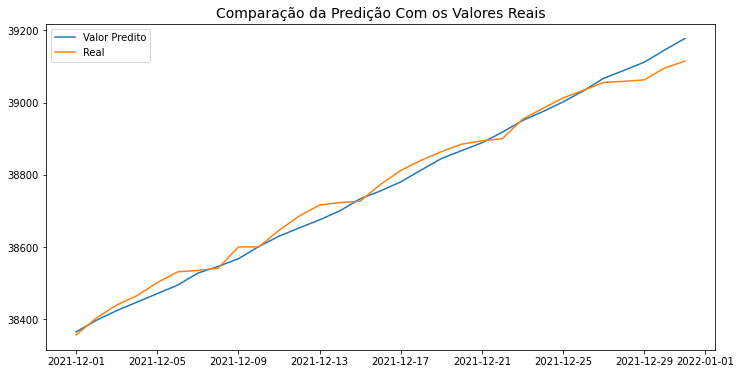

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Comparação da Predição Com os Valores Reais', fontsize=14)
plt.plot(teste.index,fc,label='Valor Predito')
plt.plot(teste.index,teste['Deaths'].values,label='Real')
plt.legend()

In [ ]:
print('MAPE:',mean_absolute_percentage_error(teste['Deaths'],fc))
print('MAE:',mean_absolute_error(teste['Deaths'],fc))
print('RMSE:',np.sqrt(mean_squared_error(teste['Deaths'],fc)))

MAPE: 0.0005365897228208754
MAE: 20.82751391577697
RMSE: 25.943980823854755
